# Testing in MLOps: Data Testing e Model Testing

In questo notebook esploreremo le principali tipologie di test in MLOps, con esempi pratici che potrete eseguire direttamente.

Il testing è un aspetto fondamentale nei progetti di Machine Learning in produzione. Mentre nel software tradizionale testiamo principalmente il codice, in MLOps dobbiamo testare anche:
- **I dati** (qualità, completezza, drift)
- **Il modello** (performance, robustezza, fairness)
- **L'integrazione** tra componenti

## Installazione delle librerie necessarie

Prima di iniziare, installiamo le librerie necessarie. La cella successiva contiene i comandi pip per installare tutti i pacchetti richiesti:


In [77]:
# Decommentate le righe seguenti per installare le librerie necessarie
!pip install pandas numpy scikit-learn pytest great-expectations matplotlib seaborn

# Librerie principali che useremo:
# - pandas, numpy: manipolazione dati
# - scikit-learn: modelli ML e metriche
# - pytest: framework di testing
# - matplotlib, seaborn: visualizzazioni


In [78]:
# Import delle librerie necessarie per il testing in MLOps
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

# Settiamo il seed per garantire riproducibilità degli esempi
np.random.seed(42)

print("✅ Librerie importate con successo!")
print("🔧 Setup completato - pronti per iniziare i test!")


✅ Librerie importate con successo!
🔧 Setup completato - pronti per iniziare i test!


## 1. Data Testing (Test sui Dati)

I test sui dati sono fondamentali per garantire la qualità e l'affidabilità dei dati che alimentano i nostri modelli.

I **data test** devono verificare:
- **Schema e formato**: struttura corretta dei dati
- **Qualità e completezza**: assenza di valori nulli, duplicati, inconsistenze
- **Plausibilità statistica**: valori entro range sensati
- **Drift detection**: cambiamenti nella distribuzione dei dati

### 1.1 Creazione di un dataset di esempio

La prossima cella creerà un dataset sintetico con alcune anomalie intenzionali che useremo per dimostrare i vari tipi di test sui dati.

In [79]:
# Creiamo un dataset sintetico per i nostri test
def create_sample_dataset() -> pd.DataFrame:
    """
    Crea un dataset di esempio con alcune anomalie intenzionali.

    Questo dataset simula dati reali e include deliberatamente:
    - Valori nulli in alcune righe
    - Outlier impossibili (età > 120, salari negativi)
    - Righe duplicate

    Returns:
        pd.DataFrame: Dataset con anomalie per testing
    """

    # Dataset base con distribuzione realistica
    data = {
        'età': np.random.randint(18, 80, 1000),
        'salario': np.random.normal(50000, 15000, 1000),
        'anni_esperienza': np.random.randint(0, 40, 1000),
        'score_credito': np.random.randint(300, 850, 1000),
        'categoria': np.random.choice(['A', 'B', 'C'], 1000)
    }

    df = pd.DataFrame(data)

    # ANOMALIE INTENZIONALI per testare i nostri controlli:

    # 1. Valori nulli (righe 10-15)
    df.loc[10:15, 'salario'] = np.nan

    # 2. Outlier impossibili
    df.loc[20, 'età'] = 150  # Età impossibile
    df.loc[21, 'salario'] = -5000  # Salario negativo

    # 3. Righe duplicate (per testare controllo duplicati)
    df.loc[998] = df.loc[997]
    df.loc[999] = df.loc[997]

    return df

# Creiamo il dataset
print("🔧 Creazione del dataset di esempio...")
df_original = create_sample_dataset()
print(f"✅ Dataset creato con {len(df_original)} righe e {len(df_original.columns)} colonne")
print("\nPrime 5 righe:")
df_original.head()


🔧 Creazione del dataset di esempio...
✅ Dataset creato con 1000 righe e 5 colonne

Prime 5 righe:


,età,salario,anni_esperienza,score_credito,categoria
0,56,70585.666948,39,559,A
1,69,39833.208605,20,504,B
2,46,67302.978080,27,358,B
3,32,44374.840574,10,770,C
4,60,39587.810697,33,765,B


### 1.2 Test di Schema e Formato

I **test di schema** verificano che i dati abbiano la struttura attesa:
- Presenza di tutte le colonne necessarie
- Tipi di dato corretti per ogni colonna
- Numero minimo di righe

Questo è il primo livello di controllo - se fallisce, i dati non sono utilizzabili.

La prossima cella implementa una funzione che verifica tutti questi aspetti:


In [80]:
def test_schema_formato(df: pd.DataFrame) -> Dict[str, bool]:
    """
    Verifica che il dataframe rispetti lo schema atteso.

    Controlla:
    1. Presenza di tutte le colonne necessarie
    2. Tipi di dato corretti per ogni colonna
    3. Numero minimo di righe per validità statistica

    Args:
        df: DataFrame da testare

    Returns:
        Dict con risultati dei test (True = PASS, False = FAIL)
    """

    test_results = {}

    # Test 1: Verifica delle colonne attese
    colonne_attese = ['età', 'salario', 'anni_esperienza', 'score_credito', 'categoria']
    colonne_presenti = list(df.columns)
    test_results['colonne_corrette'] = set(colonne_attese) == set(colonne_presenti)

    if not test_results['colonne_corrette']:
        mancanti = set(colonne_attese) - set(colonne_presenti)
        extra = set(colonne_presenti) - set(colonne_attese)
        if mancanti:
            print(f"⚠️ Colonne mancanti: {mancanti}")
        if extra:
            print(f"⚠️ Colonne extra: {extra}")

    # Test 2: Verifica dei tipi di dato
    tipi_attesi = {
        'età': 'int64',
        'salario': 'float64',
        'anni_esperienza': 'int64',
        'score_credito': 'int64',
        'categoria': 'object'
    }

    tipi_corretti = True
    for col, tipo_atteso in tipi_attesi.items():
        if col in df.columns:
            if df[col].dtype != tipo_atteso:
                tipi_corretti = False
                print(f"⚠️ Colonna '{col}': tipo {df[col].dtype} invece di {tipo_atteso}")

    test_results['tipi_corretti'] = tipi_corretti

    # Test 3: Verifica del numero minimo di righe
    test_results['righe_sufficienti'] = len(df) >= 100

    return test_results

# Eseguiamo i test di schema
print("🔍 Esecuzione test di schema e formato...")
risultati_schema = test_schema_formato(df_original)
print("\nRisultati Test di Schema:")
for test, risultato in risultati_schema.items():
    stato = "✅ PASS" if risultato else "❌ FAIL"
    print(f"  {test}: {stato}")


🔍 Esecuzione test di schema e formato...

Risultati Test di Schema:
  colonne_corrette: ✅ PASS
  tipi_corretti: ✅ PASS
  righe_sufficienti: ✅ PASS


### 1.3 Test di Qualità e Completezza

I **test di qualità** verificano l'integrità dei dati:
- **Valori nulli**: presenza di missing values
- **Duplicati**: righe identiche che potrebbero causare overfitting
- **Valori categorici**: range di valori validi per variabili categoriche

Questi test ci dicono se i dati sono "puliti" e pronti per l'uso.

La prossima cella implementa controlli dettagliati per tutti questi aspetti:


In [81]:
def test_qualita_completezza(df: pd.DataFrame) -> Dict[str, Dict]:
    """
    Verifica la qualità e completezza dei dati.

    Controlla:
    1. Valori nulli in tutte le colonne
    2. Presenza di righe duplicate
    3. Validità dei valori categorici

    Args:
        df: DataFrame da testare

    Returns:
        Dict con risultati dettagliati dei test
    """

    risultati = {}

    # Test 1: Controllo valori nulli
    valori_nulli = df.isnull().sum()
    risultati['valori_nulli'] = {
        'totale': valori_nulli.sum(),
        'per_colonna': valori_nulli.to_dict(),
        'test_passed': valori_nulli.sum() == 0
    }

    # Test 2: Controllo duplicati
    duplicati = df.duplicated().sum()
    risultati['duplicati'] = {
        'totale': duplicati,
        'percentuale': (duplicati / len(df)) * 100,
        'test_passed': duplicati == 0
    }

    # Test 3: Controllo valori unici per colonne categoriche
    valori_unici_categoria = df['categoria'].nunique()
    risultati['valori_unici_categoria'] = {
        'numero': valori_unici_categoria,
        'valori': df['categoria'].unique().tolist(),
        'test_passed': valori_unici_categoria >= 2 and valori_unici_categoria <= 10
    }

    return risultati

# Eseguiamo i test di qualità
print("🔍 Esecuzione test di qualità e completezza...")
risultati_qualita = test_qualita_completezza(df_original)

print("\n📊 Risultati Test di Qualità e Completezza:\n")
print(f"1. Valori Nulli:")
print(f"   - Totale: {risultati_qualita['valori_nulli']['totale']}")
print(f"   - Per colonna: {risultati_qualita['valori_nulli']['per_colonna']}")
print(f"   - Test: {'✅ PASS' if risultati_qualita['valori_nulli']['test_passed'] else '❌ FAIL'}")

print(f"\n2. Duplicati:")
print(f"   - Totale: {risultati_qualita['duplicati']['totale']}")
print(f"   - Percentuale: {risultati_qualita['duplicati']['percentuale']:.2f}%")
print(f"   - Test: {'✅ PASS' if risultati_qualita['duplicati']['test_passed'] else '❌ FAIL'}")

print(f"\n3. Valori Categorici:")
print(f"   - Valori unici: {risultati_qualita['valori_unici_categoria']['numero']}")
print(f"   - Valori: {risultati_qualita['valori_unici_categoria']['valori']}")
print(f"   - Test: {'✅ PASS' if risultati_qualita['valori_unici_categoria']['test_passed'] else '❌ FAIL'}")


🔍 Esecuzione test di qualità e completezza...

📊 Risultati Test di Qualità e Completezza:

1. Valori Nulli:
   - Totale: 6
   - Per colonna: {'età': 0, 'salario': 6, 'anni_esperienza': 0, 'score_credito': 0, 'categoria': 0}
   - Test: ❌ FAIL

2. Duplicati:
   - Totale: 2
   - Percentuale: 0.20%
   - Test: ❌ FAIL

3. Valori Categorici:
   - Valori unici: 3
   - Valori: ['A', 'B', 'C']
   - Test: ✅ PASS


### 1.4 Test di Plausibilità Statistica

I **test di plausibilità** verificano che i valori siano statisticamente sensati:
- **Range validation**: valori entro limiti logici (es. età 0-120)
- **Distribuzione ragionevole**: assenza di outlier estremi
- **Coerenza business**: valori che hanno senso nel contesto

Questi test catturano errori di data entry o problemi di integrazione.

La prossima cella implementa controlli di range per tutte le variabili numeriche:


In [82]:
def test_plausibilita_statistica(df: pd.DataFrame) -> Dict[str, Dict]:
    """
    Verifica che i valori rientrino in range plausibili.

    Controlla ogni colonna numerica per:
    1. Valori entro range business-logic
    2. Identificazione di outlier estremi
    3. Coerenza con aspettative di dominio

    Args:
        df: DataFrame da testare

    Returns:
        Dict con risultati dettagliati per ogni colonna
    """

    risultati = {}

    # Definizione dei range plausibili (da knowledge del dominio)
    range_plausibili = {
        'età': (0, 120),           # Range umano normale
        'salario': (0, 500000),    # Range salari plausibili
        'anni_esperienza': (0, 60), # Max esperienza lavorativa
        'score_credito': (300, 850) # Range standard score credito
    }

    for colonna, (min_val, max_val) in range_plausibili.items():
        if colonna in df.columns:
            # Rimuoviamo i NaN per il calcolo
            valori = df[colonna].dropna()

            # Troviamo valori fuori range
            fuori_range = valori[(valori < min_val) | (valori > max_val)]

            risultati[colonna] = {
                'min_valore': valori.min(),
                'max_valore': valori.max(),
                'range_atteso': (min_val, max_val),
                'valori_fuori_range': len(fuori_range),
                'test_passed': len(fuori_range) == 0
            }

            # Se ci sono valori fuori range, mostriamoli
            if len(fuori_range) > 0:
                risultati[colonna]['esempi_fuori_range'] = fuori_range.head().tolist()

    return risultati

# Eseguiamo i test di plausibilità
print("🔍 Esecuzione test di plausibilità statistica...")
risultati_plausibilita = test_plausibilita_statistica(df_original)

print("\n📊 Risultati Test di Plausibilità Statistica:\n")
for colonna, risultato in risultati_plausibilita.items():
    print(f"{colonna}:")
    print(f"  - Range atteso: {risultato['range_atteso']}")
    print(f"  - Range effettivo: ({risultato['min_valore']:.0f}, {risultato['max_valore']:.0f})")
    print(f"  - Valori fuori range: {risultato['valori_fuori_range']}")
    if risultato['valori_fuori_range'] > 0:
        print(f"  - Esempi: {risultato.get('esempi_fuori_range', [])}")
    print(f"  - Test: {'✅ PASS' if risultato['test_passed'] else '❌ FAIL'}")
    print()


🔍 Esecuzione test di plausibilità statistica...

📊 Risultati Test di Plausibilità Statistica:

età:
  - Range atteso: (0, 120)
  - Range effettivo: (18, 150)
  - Valori fuori range: 1
  - Esempi: [150]
  - Test: ❌ FAIL

salario:
  - Range atteso: (0, 500000)
  - Range effettivo: (-5000, 97617)
  - Valori fuori range: 4
  - Esempi: [-2172.538204548342, -5000.0, -3523.0794903982314, -826.4212398458985]
  - Test: ❌ FAIL

anni_esperienza:
  - Range atteso: (0, 60)
  - Range effettivo: (0, 39)
  - Valori fuori range: 0
  - Test: ✅ PASS

score_credito:
  - Range atteso: (300, 850)
  - Range effettivo: (300, 849)
  - Valori fuori range: 0
  - Test: ✅ PASS



### 1.5 Test di Drift (Simulazione)

Il **data drift** è uno dei problemi più comuni in produzione: i dati cambiano nel tempo e il modello può degradare.

**Tipi di drift**:
- **Covariate drift**: cambiano le distribuzioni delle feature (X)
- **Concept drift**: cambia la relazione X -> Y
- **Label drift**: cambia la distribuzione del target (Y)

La prossima cella simula un dataset con drift e implementa test statistici per rilevarlo:


In [83]:
def simula_data_drift() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Simula un dataset con drift rispetto all'originale.

    Crea due dataset:
    1. Training: distribuzione originale
    2. Produzione: distribuzione con drift simulato

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: (df_train, df_prod)
    """

    # Dataset originale (training) - distribuzione baseline
    df_train = pd.DataFrame({
        'età': np.random.normal(40, 10, 1000),
        'salario': np.random.normal(50000, 15000, 1000),
        'score_credito': np.random.normal(650, 100, 1000)
    })

    # Dataset con drift (produzione) - distribuzione cambiata
    # Simuliamo cambiamenti tipici che potrebbero accadere in produzione
    df_prod = pd.DataFrame({
        'età': np.random.normal(35, 12, 1000),      # Popolazione più giovane
        'salario': np.random.normal(55000, 20000, 1000),  # Salari più alti e variabili
        'score_credito': np.random.normal(620, 120, 1000)  # Score più bassi e variabili
    })

    return df_train, df_prod

def test_data_drift(df_train: pd.DataFrame, df_prod: pd.DataFrame,
                   threshold: float = 0.1) -> Dict[str, Dict]:
    """
    Testa il drift tra due dataset usando test statistici semplici.

    Confronta:
    1. Media delle distribuzioni
    2. Deviazione standard delle distribuzioni
    3. Valuta se il drift supera soglie predefinite

    Args:
        df_train: Dataset di training (baseline)
        df_prod: Dataset di produzione (confronto)
        threshold: Soglia per rilevare drift significativo

    Returns:
        Dict con risultati del test per ogni colonna
    """

    risultati = {}

    for colonna in df_train.columns:
        if colonna in df_prod.columns:
            # Calcolo statistiche di base
            mean_train = df_train[colonna].mean()
            mean_prod = df_prod[colonna].mean()
            std_train = df_train[colonna].std()
            std_prod = df_prod[colonna].std()

            # Drift della media (normalizzato per essere scale-invariant)
            drift_mean = abs(mean_prod - mean_train) / mean_train if mean_train != 0 else 0

            # Drift della deviazione standard
            drift_std = abs(std_prod - std_train) / std_train if std_train != 0 else 0

            risultati[colonna] = {
                'mean_train': mean_train,
                'mean_prod': mean_prod,
                'drift_mean_pct': drift_mean * 100,
                'drift_std_pct': drift_std * 100,
                'drift_detected': drift_mean > threshold or drift_std > threshold
            }

    return risultati

# Simuliamo e testiamo il drift
print("🔍 Simulazione e test del data drift...")
df_train, df_prod = simula_data_drift()
risultati_drift = test_data_drift(df_train, df_prod)

print("\n🔄 Risultati Test di Data Drift:\n")
for colonna, risultato in risultati_drift.items():
    print(f"{colonna}:")
    print(f"  - Media training: {risultato['mean_train']:.2f}")
    print(f"  - Media produzione: {risultato['mean_prod']:.2f}")
    print(f"  - Drift media: {risultato['drift_mean_pct']:.1f}%")
    print(f"  - Drift std: {risultato['drift_std_pct']:.1f}%")
    print(f"  - Drift rilevato: {'⚠️ SI' if risultato['drift_detected'] else '✅ NO'}")
    print()


🔍 Simulazione e test del data drift...

🔄 Risultati Test di Data Drift:

età:
  - Media training: 40.13
  - Media produzione: 35.28
  - Drift media: 12.1%
  - Drift std: 23.5%
  - Drift rilevato: ⚠️ SI

salario:
  - Media training: 49699.19
  - Media produzione: 54689.09
  - Drift media: 10.0%
  - Drift std: 36.8%
  - Drift rilevato: ⚠️ SI

score_credito:
  - Media training: 652.95
  - Media produzione: 615.16
  - Drift media: 5.8%
  - Drift std: 19.5%
  - Drift rilevato: ⚠️ SI



📊 Creazione visualizzazione comparativa del drift...


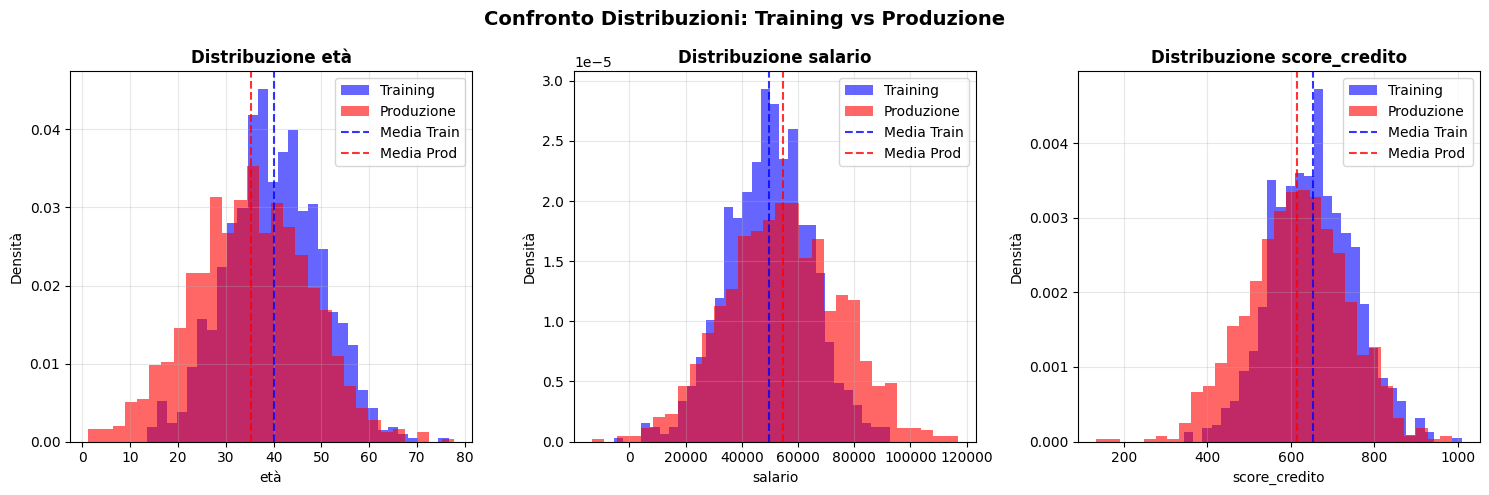

✅ Visualizzazione completata!

💡 Osservazioni:
- Le aree blu mostrano la distribuzione originale (training)
- Le aree rosse mostrano la distribuzione con drift (produzione)
- Le linee tratteggiate indicano le medie delle distribuzioni


In [84]:
# Visualizziamo il drift con istogrammi comparativi
print("📊 Creazione visualizzazione comparativa del drift...")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, col in enumerate(['età', 'salario', 'score_credito']):
    # Istogrammi sovrapposti per confronto visivo
    axes[idx].hist(df_train[col], bins=30, alpha=0.6, label='Training', density=True, color='blue')
    axes[idx].hist(df_prod[col], bins=30, alpha=0.6, label='Produzione', density=True, color='red')

    # Linee verticali per le medie
    axes[idx].axvline(df_train[col].mean(), color='blue', linestyle='--', alpha=0.8, label='Media Train')
    axes[idx].axvline(df_prod[col].mean(), color='red', linestyle='--', alpha=0.8, label='Media Prod')

    axes[idx].set_title(f'Distribuzione {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Densità')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Confronto Distribuzioni: Training vs Produzione', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Visualizzazione completata!")
print("\n💡 Osservazioni:")
print("- Le aree blu mostrano la distribuzione originale (training)")
print("- Le aree rosse mostrano la distribuzione con drift (produzione)")
print("- Le linee tratteggiate indicano le medie delle distribuzioni")


### 1.6 Test con Great Expectations - Validazione Professionale dei Dati

**Great Expectations** è una libreria Python che permette di definire "aspettative" sui dati in modo dichiarativo e documentato.

**Vantaggi di Great Expectations:**
- **Dichiarativo**: Definisci cosa ti aspetti dai dati, non come verificarlo
- **Documentazione automatica**: Genera report HTML dettagliati
- **Integrazione**: Si integra facilmente con pipeline di data engineering
- **Versioning**: Traccia le aspettative nel tempo
- **Profiling automatico**: Scopre automaticamente pattern nei dati

**Workflow tipico:**
1. **Profiling** automatico dei dati per scoprire pattern
2. **Definizione** delle aspettative (expectations)
3. **Validazione** dei dati rispetto alle aspettative
4. **Generazione** di report dettagliati

Per motivi di tempo non abbiamo tempo di configurare un progetto con Great Expectation, ma vi invitiamo a farlo consultando il [sito ufficiale](https://greatexpectations.io/expectations/) o questo [link](https://www.youtube.com/watch?v=F3yvXqzkDhU).

## 2. Model Testing (Test sul Modello)

Ora passiamo ai test sul modello stesso, che valutano performance, robustezza e fairness.

I **model test** devono verificare:
- **Performance**: metriche sopra soglie minime accettabili
- **Robustezza**: stabilità con dati perturbati o incompleti
- **Stabilità**: risultati consistenti con diversi seed/configurazioni
- **Fairness**: equità tra diversi gruppi demografici
- **Slicing**: performance su sottopopolazioni specifiche

### 2.1 Preparazione del modello di esempio

La prossima cella crea un dataset sintetico per la classificazione e addestra un modello RandomForest che useremo per tutti i test successivi:


In [87]:
# Creiamo un dataset sintetico per il nostro modello di classificazione
print("🔧 Creazione dataset sintetico per model testing...")

# Dataset con 1000 campioni, 10 features, 8 informative
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=8,      # Features correlate al target
    n_redundant=2,        # Features ridondanti
    random_state=42
)

# Creiamo un DataFrame completo con metadati per test avanzati
df_model = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(10)])
df_model['target'] = y

# Aggiungiamo gruppi demografici per test di fairness
# Gruppo A: 60%, Gruppo B: 40% (riflette sbilanciamento reale)
df_model['gruppo'] = np.random.choice(['A', 'B'], size=1000, p=[0.6, 0.4])

print(f"✅ Dataset creato: {df_model.shape[0]} campioni, {df_model.shape[1]-2} features")
print(f"   - Target distribution: {dict(df_model['target'].value_counts())}")
print(f"   - Gruppi demografici: {dict(df_model['gruppo'].value_counts())}")

# Split dei dati mantenendo gli indici originali
X_train, X_test, y_train, y_test = train_test_split(
    df_model.drop(['target', 'gruppo'], axis=1),
    df_model['target'],
    test_size=0.2,
    random_state=42,
    stratify=df_model['target']  # Manteniamo la distribuzione del target
)

print(f"\\n📊 Split completato:")
print(f"   - Training set: {X_train.shape[0]} campioni")
print(f"   - Test set: {X_test.shape[0]} campioni")

# Training del modello
print("\\n🤖 Addestramento RandomForest...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Valutazione iniziale
accuracy_baseline = accuracy_score(y_test, model.predict(X_test))
print(f"✅ Modello addestrato con successo!")
print(f"   - Accuracy baseline sul test set: {accuracy_baseline:.3f}")
print(f"   - Pronto per i test di robustezza e fairness")


🔧 Creazione dataset sintetico per model testing...
✅ Dataset creato: 1000 campioni, 10 features
   - Target distribution: {1: 500, 0: 500}
   - Gruppi demografici: {'A': 596, 'B': 404}
\n📊 Split completato:
   - Training set: 800 campioni
   - Test set: 200 campioni
\n🤖 Addestramento RandomForest...
✅ Modello addestrato con successo!
   - Accuracy baseline sul test set: 0.860
   - Pronto per i test di robustezza e fairness


### 2.2 Test di Performance

I **test di performance** verificano che il modello raggiunga standard minimi accettabili:
- **Accuracy**: percentuale di predizioni corrette
- **Precision**: correttezza delle predizioni positive
- **Recall**: capacità di trovare tutti i casi positivi
- **F1-Score**: bilancio tra precision e recall

Questi test implementano **acceptance criteria** - soglie sotto cui il modello non è accettabile per la produzione.

La prossima cella implementa controlli automatici per tutte le metriche principali:


In [88]:
def test_performance_modello(model, X_test, y_test,
                           soglie_minime: Dict[str, float] = None) -> Dict[str, Dict]:
    """
    Testa le performance del modello rispetto a soglie minime (acceptance criteria).

    Valuta se il modello è accettabile per la produzione basandosi su:
    1. Accuracy minima richiesta
    2. Precision minima (riduce falsi positivi)
    3. Recall minima (riduce falsi negativi)
    4. F1-Score minimo (bilancio generale)

    Args:
        model: Modello addestrato
        X_test: Features di test
        y_test: Target di test
        soglie_minime: Dict con soglie per ogni metrica

    Returns:
        Dict con risultati dettagliati per ogni metrica
    """

    # Soglie di default (da definire con business stakeholders)
    if soglie_minime is None:
        soglie_minime = {
            'accuracy': 0.7,    # 70% accuracy minima
            'precision': 0.7,   # 70% precision minima
            'recall': 0.7,      # 70% recall minima
            'f1': 0.7          # 70% F1-score minima
        }

    # Predizioni
    y_pred = model.predict(X_test)

    # Calcolo metriche standard
    metriche = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }

    # Test rispetto alle soglie (acceptance criteria)
    risultati = {}
    for metrica, valore in metriche.items():
        soglia = soglie_minime.get(metrica, 0.7)
        risultati[metrica] = {
            'valore': valore,
            'soglia_minima': soglia,
            'test_passed': valore >= soglia,
            'margine': valore - soglia  # Quanto sopra/sotto la soglia
        }

    return risultati

# Eseguiamo i test di performance
print("🔍 Esecuzione test di performance...")
risultati_performance = test_performance_modello(model, X_test, y_test)

print("\n📈 Risultati Test di Performance del Modello:\n")
for metrica, risultato in risultati_performance.items():
    stato = "✅ PASS" if risultato['test_passed'] else "❌ FAIL"
    margine_str = f"(+{risultato['margine']:.3f})" if risultato['margine'] > 0 else f"({risultato['margine']:.3f})"

    print(f"{metrica.capitalize()}:")
    print(f"  - Valore: {risultato['valore']:.3f}")
    print(f"  - Soglia minima: {risultato['soglia_minima']:.3f}")
    print(f"  - Margine: {margine_str}")
    print(f"  - Test: {stato}")
    print()

# Verifica generale
tutti_pass = all(risultato['test_passed'] for risultato in risultati_performance.values())
print(f"🎯 Verdetto finale: {'✅ MODELLO ACCETTABILE' if tutti_pass else '❌ MODELLO NON ACCETTABILE'}")
if not tutti_pass:
    print("   ⚠️ Il modello non raggiunge gli standard minimi richiesti per la produzione")


🔍 Esecuzione test di performance...

📈 Risultati Test di Performance del Modello:

Accuracy:
  - Valore: 0.860
  - Soglia minima: 0.700
  - Margine: (+0.160)
  - Test: ✅ PASS

Precision:
  - Valore: 0.861
  - Soglia minima: 0.700
  - Margine: (+0.161)
  - Test: ✅ PASS

Recall:
  - Valore: 0.860
  - Soglia minima: 0.700
  - Margine: (+0.160)
  - Test: ✅ PASS

F1:
  - Valore: 0.860
  - Soglia minima: 0.700
  - Margine: (+0.160)
  - Test: ✅ PASS

🎯 Verdetto finale: ✅ MODELLO ACCETTABILE


### 2.3 Test di Robustezza (Stress Test)

I **test di robustezza** verificano come il modello si comporta con dati imperfetti o perturbati:
- **Rumore gaussiano**: aggiunta di rumore casuale alle features
- **Valori mancanti**: simulazione di missing values
- **Outlier**: valori estremi o anomali
- **Corrupted data**: dati parzialmente danneggiati

Questi test simulano condizioni reali di produzione dove i dati potrebbero essere meno "puliti" del training set.

La prossima cella implementa stress test sistematici con diversi livelli di perturbazione:


In [89]:
def test_robustezza_modello(model, X_test, y_test) -> Dict[str, Dict]:
    """
    Testa la robustezza del modello con dati perturbati (stress test).

    Simula condizioni avverse di produzione:
    1. Rumore gaussiano con intensità crescente
    2. Valori mancanti con percentuali crescenti
    3. Valuta la degradazione rispetto al baseline

    Args:
        model: Modello addestrato
        X_test: Features di test
        y_test: Target di test

    Returns:
        Dict con risultati dettagliati per ogni tipo di perturbazione
    """

    risultati = {}

    # Performance baseline (condizioni ideali)
    y_pred_baseline = model.predict(X_test)
    acc_baseline = accuracy_score(y_test, y_pred_baseline)

    # Test 1: Robustezza al rumore gaussiano
    noise_levels = [0.1, 0.5, 1.0]  # Intensità crescente di rumore
    risultati['rumore_gaussiano'] = {}

    for noise_level in noise_levels:
        # Aggiungiamo rumore gaussiano alle features
        X_noisy = X_test + np.random.normal(0, noise_level, X_test.shape)
        y_pred_noisy = model.predict(X_noisy)
        acc_noisy = accuracy_score(y_test, y_pred_noisy)

        # Calcolo degradazione percentuale
        degradazione = (acc_baseline - acc_noisy) / acc_baseline * 100

        risultati['rumore_gaussiano'][f'noise_{noise_level}'] = {
            'accuracy': acc_noisy,
            'degradazione_pct': degradazione,
            'test_passed': degradazione < 20  # Soglia: max 20% degradazione
        }

    # Test 2: Robustezza ai valori mancanti
    missing_rates = [0.1, 0.2, 0.3]  # 10%, 20%, 30% valori mancanti
    risultati['valori_mancanti'] = {}

    for missing_rate in missing_rates:
        X_missing = X_test.copy()
        # Creiamo una maschera casuale per i valori mancanti
        mask = np.random.random(X_missing.shape) < missing_rate
        X_missing[mask] = 0  # Sostituiamo con 0 (strategia semplice)

        y_pred_missing = model.predict(X_missing)
        acc_missing = accuracy_score(y_test, y_pred_missing)

        degradazione = (acc_baseline - acc_missing) / acc_baseline * 100

        risultati['valori_mancanti'][f'missing_{int(missing_rate*100)}pct'] = {
            'accuracy': acc_missing,
            'degradazione_pct': degradazione,
            'test_passed': degradazione < 30  # Soglia: max 30% degradazione
        }

    risultati['baseline'] = {'accuracy': acc_baseline}

    return risultati

# Eseguiamo i test di robustezza
print("🔍 Esecuzione stress test di robustezza...")
risultati_robustezza = test_robustezza_modello(model, X_test, y_test)

print("\n🛡️ Risultati Test di Robustezza (Stress Test):\n")
print(f"Accuracy baseline: {risultati_robustezza['baseline']['accuracy']:.3f}")
print("(Performance in condizioni ideali)\n")

print("1. Test con Rumore Gaussiano:")
for test, risultato in risultati_robustezza['rumore_gaussiano'].items():
    stato = "✅ PASS" if risultato['test_passed'] else "❌ FAIL"
    print(f"  {test}:")
    print(f"    - Accuracy: {risultato['accuracy']:.3f}")
    print(f"    - Degradazione: {risultato['degradazione_pct']:.1f}%")
    print(f"    - Test: {stato}")

print("\n2. Test con Valori Mancanti:")
for test, risultato in risultati_robustezza['valori_mancanti'].items():
    stato = "✅ PASS" if risultato['test_passed'] else "❌ FAIL"
    print(f"  {test}:")
    print(f"    - Accuracy: {risultato['accuracy']:.3f}")
    print(f"    - Degradazione: {risultato['degradazione_pct']:.1f}%")
    print(f"    - Test: {stato}")

# Verifica generale della robustezza
tutti_rumore_pass = all(r['test_passed'] for r in risultati_robustezza['rumore_gaussiano'].values())
tutti_missing_pass = all(r['test_passed'] for r in risultati_robustezza['valori_mancanti'].values())
robustezza_generale = tutti_rumore_pass and tutti_missing_pass

print(f"\n🎯 Verdetto robustezza: {'✅ MODELLO ROBUSTO' if robustezza_generale else '❌ MODELLO FRAGILE'}")
if not robustezza_generale:
    print("   ⚠️ Il modello è sensibile a perturbazioni dei dati")


🔍 Esecuzione stress test di robustezza...

🛡️ Risultati Test di Robustezza (Stress Test):

Accuracy baseline: 0.860
(Performance in condizioni ideali)

1. Test con Rumore Gaussiano:
  noise_0.1:
    - Accuracy: 0.830
    - Degradazione: 3.5%
    - Test: ✅ PASS
  noise_0.5:
    - Accuracy: 0.820
    - Degradazione: 4.7%
    - Test: ✅ PASS
  noise_1.0:
    - Accuracy: 0.785
    - Degradazione: 8.7%
    - Test: ✅ PASS

2. Test con Valori Mancanti:
  missing_10pct:
    - Accuracy: 0.825
    - Degradazione: 4.1%
    - Test: ✅ PASS
  missing_20pct:
    - Accuracy: 0.770
    - Degradazione: 10.5%
    - Test: ✅ PASS
  missing_30pct:
    - Accuracy: 0.800
    - Degradazione: 7.0%
    - Test: ✅ PASS

🎯 Verdetto robustezza: ✅ MODELLO ROBUSTO


### 2.4 Test di Stabilità

I **test di stabilità** verificano la consistenza del modello:
- **Variabilità tra run**: performance simili con seed diversi
- **Determinismo**: risultati riproducibili
- **Agreement tra modelli**: consenso tra istanze multiple

Un modello instabile può avere performance variabili in produzione e risultati non affidabili.

La prossima cella addestra più istanze del modello con seed diversi per valutare la stabilità:


🔄 Addestramento di 5 modelli con seed diversi...
  Run 1: Accuracy = 0.860
  Run 2: Accuracy = 0.830
  Run 3: Accuracy = 0.850
  Run 4: Accuracy = 0.855
  Run 5: Accuracy = 0.855

📊 Risultati Test di Stabilità del Modello:

Accuracy media: 0.850 ± 0.010
Coefficiente di variazione: 0.012
Agreement medio tra modelli: 97.3%

Test: ✅ PASS
(Criteri: CV < 0.05 e Agreement > 90%)

📈 Creazione visualizzazioni di stabilità...


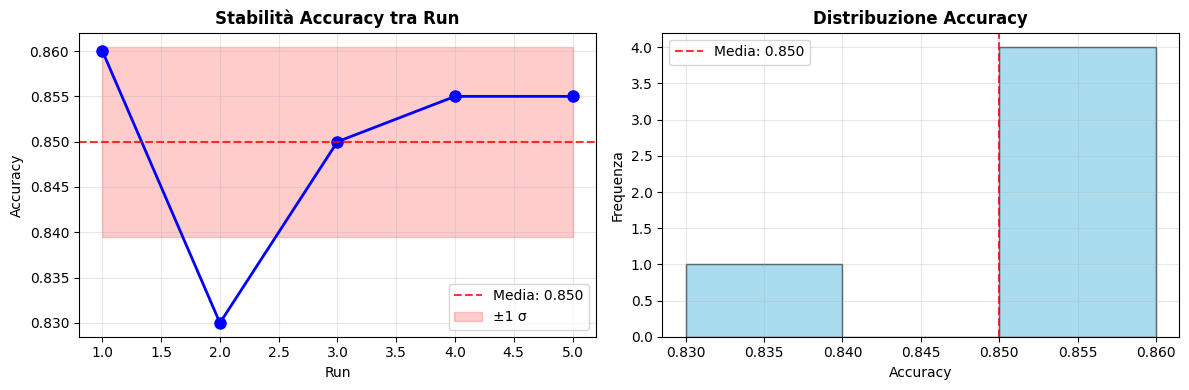

✅ Visualizzazioni completate!

💡 Interpretazione:
- CV basso (0.012) indica performance consistenti
- Agreement alto (97.3%) indica predizioni affidabili
- Modello stabile per la produzione


In [90]:
def test_stabilita_modello(X_train, y_train, X_test, y_test, n_runs=5):
    """
    Testa la stabilità del modello con diversi seed casuali.

    Valuta:
    1. Variabilità delle performance tra run diversi
    2. Accordo tra predizioni di modelli diversi
    3. Coefficiente di variazione delle metriche

    Args:
        X_train, y_train: Dati di training
        X_test, y_test: Dati di test
        n_runs: Numero di run con seed diversi

    Returns:
        Tuple[Dict, List]: (risultati statistici, lista accuracy)
    """

    print(f"🔄 Addestramento di {n_runs} modelli con seed diversi...")

    accuracies = []
    predictions_list = []

    for seed in range(n_runs):
        # Addestra modello con seed diverso
        model_temp = RandomForestClassifier(n_estimators=100, random_state=seed)
        model_temp.fit(X_train, y_train)

        # Valuta performance
        y_pred = model_temp.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        accuracies.append(accuracy)
        predictions_list.append(y_pred)

        print(f"  Run {seed+1}: Accuracy = {accuracy:.3f}")

    # Calcola statistiche di stabilità
    acc_mean = np.mean(accuracies)
    acc_std = np.std(accuracies)
    acc_cv = acc_std / acc_mean  # Coefficiente di variazione

    # Calcola agreement tra predizioni
    predictions_array = np.array(predictions_list)
    agreement_rates = []

    for i in range(len(X_test)):
        preds_for_sample = predictions_array[:, i]
        # Percentuale di modelli che concordano sulla predizione più comune
        most_common_pred = np.bincount(preds_for_sample).argmax()
        agreement_rate = (preds_for_sample == most_common_pred).mean()
        agreement_rates.append(agreement_rate)

    mean_agreement = np.mean(agreement_rates)

    risultati = {
        'accuracy_mean': acc_mean,
        'accuracy_std': acc_std,
        'coefficient_variation': acc_cv,
        'mean_agreement': mean_agreement,
        'test_passed': acc_cv < 0.05 and mean_agreement > 0.9
    }

    return risultati, accuracies

# Eseguiamo il test di stabilità
risultati_stabilita, accuracies = test_stabilita_modello(X_train, y_train, X_test, y_test)

print("\n📊 Risultati Test di Stabilità del Modello:\n")
print(f"Accuracy media: {risultati_stabilita['accuracy_mean']:.3f} ± {risultati_stabilita['accuracy_std']:.3f}")
print(f"Coefficiente di variazione: {risultati_stabilita['coefficient_variation']:.3f}")
print(f"Agreement medio tra modelli: {risultati_stabilita['mean_agreement']:.1%}")
print(f"\nTest: {'✅ PASS' if risultati_stabilita['test_passed'] else '❌ FAIL'}")
print(f"(Criteri: CV < 0.05 e Agreement > 90%)")

# Visualizzazione della stabilità
print("\n📈 Creazione visualizzazioni di stabilità...")
plt.figure(figsize=(12, 4))

# Grafico 1: Andamento accuracy tra run
plt.subplot(1, 2, 1)
plt.plot(range(1, len(accuracies)+1), accuracies, 'o-', color='blue', linewidth=2, markersize=8)
plt.axhline(y=risultati_stabilita['accuracy_mean'], color='red', linestyle='--', alpha=0.8, label=f'Media: {risultati_stabilita["accuracy_mean"]:.3f}')
plt.fill_between(range(1, len(accuracies)+1),
                 risultati_stabilita['accuracy_mean'] - risultati_stabilita['accuracy_std'],
                 risultati_stabilita['accuracy_mean'] + risultati_stabilita['accuracy_std'],
                 alpha=0.2, color='red', label='±1 σ')
plt.xlabel('Run')
plt.ylabel('Accuracy')
plt.title('Stabilità Accuracy tra Run', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Grafico 2: Distribuzione accuracy
plt.subplot(1, 2, 2)
plt.hist(accuracies, bins=max(3, len(accuracies)//2), edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(risultati_stabilita['accuracy_mean'], color='red', linestyle='--', alpha=0.8, label=f'Media: {risultati_stabilita["accuracy_mean"]:.3f}')
plt.xlabel('Accuracy')
plt.ylabel('Frequenza')
plt.title('Distribuzione Accuracy', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualizzazioni completate!")
print(f"\n💡 Interpretazione:")
print(f"- CV basso ({risultati_stabilita['coefficient_variation']:.3f}) indica performance consistenti")
print(f"- Agreement alto ({risultati_stabilita['mean_agreement']:.1%}) indica predizioni affidabili")
print(f"- Modello {'stabile' if risultati_stabilita['test_passed'] else 'instabile'} per la produzione")


### 2.5 Test di Fairness

I **test di fairness** verificano l'equità del modello tra diversi gruppi:
- **Demographic parity**: tassi di predizione simili tra gruppi
- **Equalized odds**: performance simili tra gruppi
- **Calibration**: predizioni ugualmente affidabili

La fairness è cruciale per evitare discriminazioni e bias sistemici.

La prossima cella implementa test di fairness confrontando le performance tra gruppi demografici:


#### 💡 Nota Tecnica: Gestione degli Indici in Pandas

Quando lavoriamo con train/test split e vogliamo mantenere la traccia di gruppi demografici, dobbiamo fare attenzione all'indicizzazione:

- **`.iloc`**: Indicizzazione posizionale (0, 1, 2, ...)
- **`.loc`**: Indicizzazione basata su etichette (indici originali del DataFrame)

Il train/test split mantiene gli indici originali, quindi dobbiamo usare `.loc` per accedere correttamente ai dati.

**Esempio**:
```python
# Corretto: usa .loc per indici originali
df_test_groups = df_model.loc[X_test.index]['gruppo']

# Errato: .iloc causerebbe IndexError
# df_test_groups = df_model.iloc[X_test.index]['gruppo']
```

La prossima cella implementa i test di fairness con la gestione corretta degli indici:


In [91]:
def test_fairness_modello(model, X_test, y_test, df_test_groups):
    """
    Testa la fairness del modello tra diversi gruppi demografici.

    Valuta:
    1. Performance per ogni gruppo demografico
    2. Disparità tra gruppi (accuracy, positive rate)
    3. Soglie di accettabilità per fairness

    Args:
        model: Modello addestrato
        X_test: Features di test
        y_test: Target di test
        df_test_groups: DataFrame con info demografiche per test set

    Returns:
        Tuple[Dict, Dict]: (risultati per gruppo, test disparità)
    """

    # Predizioni
    y_pred = model.predict(X_test)

    # Calcola metriche per gruppo
    risultati_per_gruppo = {}

    for gruppo in df_test_groups['gruppo'].unique():
        mask = df_test_groups['gruppo'] == gruppo
        indices = df_test_groups[mask].index

        # Troviamo le posizioni corrette nel test set usando .loc
        # Manteniamo la corrispondenza tra indici originali e posizioni nel test set
        test_positions = [list(y_test.index).index(idx) for idx in indices if idx in y_test.index]

        y_true_gruppo = y_test.iloc[test_positions]
        y_pred_gruppo = y_pred[test_positions]

        risultati_per_gruppo[gruppo] = {
            'n_samples': len(y_true_gruppo),
            'accuracy': accuracy_score(y_true_gruppo, y_pred_gruppo),
            'precision': precision_score(y_true_gruppo, y_pred_gruppo, average='weighted'),
            'recall': recall_score(y_true_gruppo, y_pred_gruppo, average='weighted'),
            'positive_rate': (y_pred_gruppo == 1).mean()
        }

    # Calcola disparità tra gruppi
    gruppi = list(risultati_per_gruppo.keys())
    if len(gruppi) >= 2:
        acc_diff = abs(risultati_per_gruppo[gruppi[0]]['accuracy'] -
                      risultati_per_gruppo[gruppi[1]]['accuracy'])
        pr_diff = abs(risultati_per_gruppo[gruppi[0]]['positive_rate'] -
                     risultati_per_gruppo[gruppi[1]]['positive_rate'])

        fairness_test = {
            'accuracy_difference': acc_diff,
            'positive_rate_difference': pr_diff,
            'test_passed': acc_diff < 0.1 and pr_diff < 0.1  # Soglia 10%
        }
    else:
        fairness_test = None

    return risultati_per_gruppo, fairness_test

# Prepariamo i dati per il test di fairness
print("🔍 Preparazione dati per test di fairness...")
# NOTA: Usiamo .loc invece di .iloc per indicizzazione basata su etichette originali
df_test_groups = df_model.loc[X_test.index][['gruppo']]

print(f"   - Gruppi nel test set: {dict(df_test_groups['gruppo'].value_counts())}")

# Eseguiamo il test
risultati_gruppo, fairness_test = test_fairness_modello(model, X_test, y_test, df_test_groups)

print("\n⚖️ Risultati Test di Fairness del Modello:\n")
print("📊 Metriche per gruppo:")
for gruppo, metriche in risultati_gruppo.items():
    print(f"\nGruppo {gruppo}:")
    print(f"  - N. campioni: {metriche['n_samples']}")
    print(f"  - Accuracy: {metriche['accuracy']:.3f}")
    print(f"  - Precision: {metriche['precision']:.3f}")
    print(f"  - Recall: {metriche['recall']:.3f}")
    print(f"  - Tasso positivi: {metriche['positive_rate']:.3f}")

if fairness_test:
    print("\n🔍 Test di disparità:")
    print(f"  - Differenza accuracy: {fairness_test['accuracy_difference']:.3f}")
    print(f"  - Differenza tasso positivi: {fairness_test['positive_rate_difference']:.3f}")
    print(f"  - Test: {'✅ PASS' if fairness_test['test_passed'] else '❌ FAIL'}")
    print(f"  (Soglia: differenza < 0.1 per entrambe le metriche)")

    # Verdetto finale
    if fairness_test['test_passed']:
        print("\n🎯 Verdetto: ✅ MODELLO EQUO")
        print("   Il modello non mostra bias significativi tra gruppi")
    else:
        print("\n🎯 Verdetto: ❌ MODELLO CON BIAS")
        print("   Il modello mostra disparità significative tra gruppi")
        print("   ⚠️ Considerare tecniche di bias mitigation")


🔍 Preparazione dati per test di fairness...
   - Gruppi nel test set: {'A': 115, 'B': 85}

⚖️ Risultati Test di Fairness del Modello:

📊 Metriche per gruppo:

Gruppo B:
  - N. campioni: 85
  - Accuracy: 0.812
  - Precision: 0.820
  - Recall: 0.812
  - Tasso positivi: 0.529

Gruppo A:
  - N. campioni: 115
  - Accuracy: 0.896
  - Precision: 0.896
  - Recall: 0.896
  - Tasso positivi: 0.530

🔍 Test di disparità:
  - Differenza accuracy: 0.084
  - Differenza tasso positivi: 0.001
  - Test: ✅ PASS
  (Soglia: differenza < 0.1 per entrambe le metriche)

🎯 Verdetto: ✅ MODELLO EQUO
   Il modello non mostra bias significativi tra gruppi


### 2.6 Test su Sottopopolazioni (Slicing)

I **test di slicing** valutano le performance su sottopopolazioni specifiche dei dati:
- **Slicing per quartili**: performance su diversi range di valori
- **Slicing per categorie**: performance su sottogruppi specifici
- **Edge cases**: performance su casi limite

Questi test rivelano se il modello ha "punti ciechi" su specifiche sottopopolazioni.

La prossima cella implementa slicing basato sui quartili di una feature e visualizza i risultati:


🔍 Esecuzione test di slicing su sottopopolazioni...
📊 Tipo di X_test: <class 'pandas.core.frame.DataFrame'> - Forma: (200, 10)
📊 Quartili per slicing (feature_0): [-1.23025976 -0.05800049  1.07533764]

🔍 Risultati Test su Sottopopolazioni (Slicing):

Performance globale: 0.860
N. campioni totali: 200

Performance per slice (basate su feature_0):

Q1 (basso):
  - N. campioni: 50
  - Accuracy: 0.860
  - Degradazione: 0.0%
  - Test: ✅ PASS

Q2:
  - N. campioni: 50
  - Accuracy: 0.900
  - Degradazione: -4.7%
  - Test: ✅ PASS

Q3:
  - N. campioni: 50
  - Accuracy: 0.820
  - Degradazione: 4.7%
  - Test: ✅ PASS

Q4 (alto):
  - N. campioni: 50
  - Accuracy: 0.860
  - Degradazione: 0.0%
  - Test: ✅ PASS

📊 Creazione visualizzazione performance per slice...


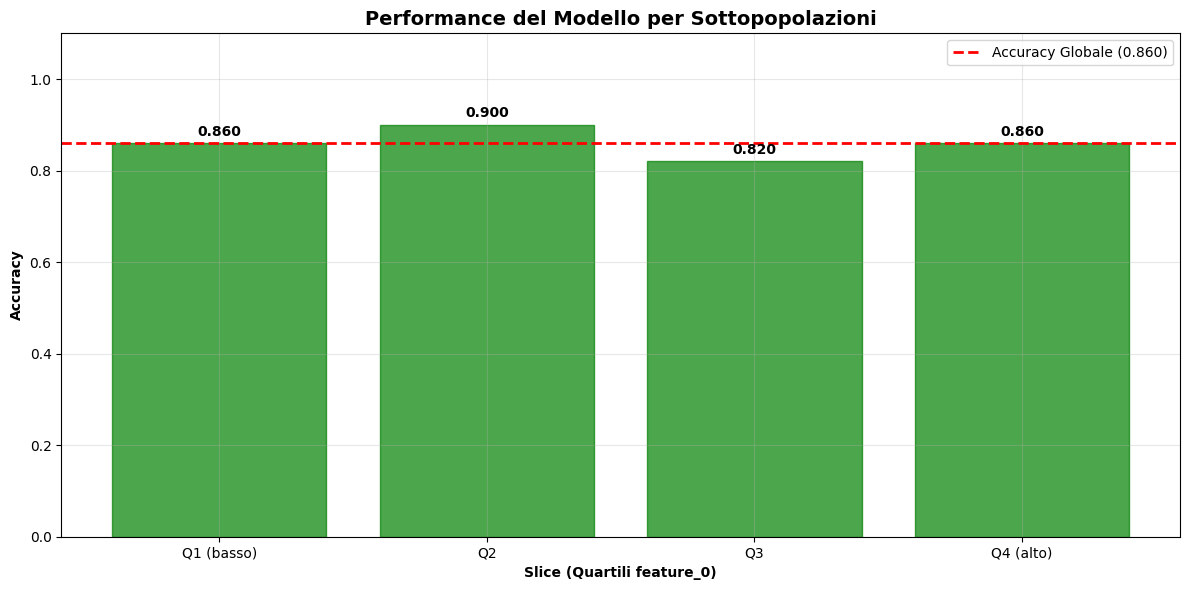


🎯 Verdetto: ✅ PERFORMANCE CONSISTENTI
   Il modello mantiene buone performance su tutte le slice
✅ Test di slicing completato!


In [92]:
def test_slicing_performance(model, X_test, y_test):
    """
    Testa le performance del modello su diverse slice dei dati.

    Crea slice basate sui quartili di una feature e valuta:
    1. Performance per ogni slice
    2. Degradazione rispetto alla performance globale
    3. Identificazione di sottopopolazioni problematiche

    Args:
        model: Modello addestrato
        X_test: Features di test (DataFrame)
        y_test: Target di test (Series)

    Returns:
        Dict con risultati per ogni slice
    """

    # Definiamo le slice basate sui quartili della prima feature
    # Utilizziamo .iloc[:, 0] per accedere alla prima colonna del DataFrame
    feature_for_slicing = X_test.iloc[:, 0].values  # Prima feature come base per slicing
    quartiles = np.percentile(feature_for_slicing, [25, 50, 75])

    print(f"📊 Quartili per slicing ({X_test.columns[0]}): {quartiles}")

    slices = {
        'Q1 (basso)': feature_for_slicing <= quartiles[0],
        'Q2': (feature_for_slicing > quartiles[0]) & (feature_for_slicing <= quartiles[1]),
        'Q3': (feature_for_slicing > quartiles[1]) & (feature_for_slicing <= quartiles[2]),
        'Q4 (alto)': feature_for_slicing > quartiles[2]
    }

    # Performance globale come baseline
    y_pred_all = model.predict(X_test)
    acc_global = accuracy_score(y_test, y_pred_all)

    risultati_slice = {'globale': {'accuracy': acc_global, 'n_samples': len(y_test)}}

    # Performance per slice
    for slice_name, mask in slices.items():
        if mask.sum() > 0:  # Se ci sono campioni nella slice
            # Usiamo .loc per indicizzazione corretta con la maschera booleana
            X_slice = X_test.loc[mask]
            y_slice = y_test.loc[mask]
            y_pred_slice = model.predict(X_slice)

            acc_slice = accuracy_score(y_slice, y_pred_slice)

            # Calcola degradazione rispetto a performance globale
            degradazione = (acc_global - acc_slice) / acc_global * 100

            risultati_slice[slice_name] = {
                'accuracy': acc_slice,
                'n_samples': len(y_slice),
                'degradazione': degradazione,
                'test_passed': degradazione < 20  # Soglia: max 20% degradazione
            }

    return risultati_slice

# Eseguiamo il test di slicing
print("🔍 Esecuzione test di slicing su sottopopolazioni...")
print(f"📊 Tipo di X_test: {type(X_test)} - Forma: {X_test.shape}")

# Eseguiamo il test con gestione errori
try:
    risultati_slicing = test_slicing_performance(model, X_test, y_test)

    print("\n🔍 Risultati Test su Sottopopolazioni (Slicing):\n")
    print(f"Performance globale: {risultati_slicing['globale']['accuracy']:.3f}")
    print(f"N. campioni totali: {risultati_slicing['globale']['n_samples']}\n")

    print(f"Performance per slice (basate su {X_test.columns[0]}):")
    for slice_name, risultato in risultati_slicing.items():
        if slice_name != 'globale':
            stato = "✅ PASS" if risultato['test_passed'] else "❌ FAIL"
            print(f"\n{slice_name}:")
            print(f"  - N. campioni: {risultato['n_samples']}")
            print(f"  - Accuracy: {risultato['accuracy']:.3f}")
            print(f"  - Degradazione: {risultato['degradazione']:.1f}%")
            print(f"  - Test: {stato}")

    # Visualizzazione con colori basati sui test
    print("\n📊 Creazione visualizzazione performance per slice...")
    slice_names = [k for k in risultati_slicing.keys() if k != 'globale']
    slice_accs = [risultati_slicing[k]['accuracy'] for k in slice_names]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(slice_names, slice_accs)
    plt.axhline(y=risultati_slicing['globale']['accuracy'], color='red',
                linestyle='--', linewidth=2, label=f'Accuracy Globale ({risultati_slicing["globale"]["accuracy"]:.3f})')

    # Colora le barre in base al test (verde=pass, rosso=fail)
    for i, (slice_name, bar) in enumerate(zip(slice_names, bars)):
        if risultati_slicing[slice_name]['test_passed']:
            bar.set_color('green')
            bar.set_alpha(0.7)
        else:
            bar.set_color('red')
            bar.set_alpha(0.7)

    # Aggiungi etichette sui valori
    for i, (slice_name, acc) in enumerate(zip(slice_names, slice_accs)):
        plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.xlabel(f'Slice (Quartili {X_test.columns[0]})', fontweight='bold')
    plt.ylabel('Accuracy', fontweight='bold')
    plt.title('Performance del Modello per Sottopopolazioni', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

    # Verdetto finale
    slices_problematiche = [k for k in slice_names if not risultati_slicing[k]['test_passed']]
    if slices_problematiche:
        print(f"\n🎯 Verdetto: ❌ SOTTOPOPOLAZIONI PROBLEMATICHE")
        print(f"   Slice con performance degradate: {slices_problematiche}")
        print("   ⚠️ Il modello ha bias verso alcune sottopopolazioni")
    else:
        print(f"\n🎯 Verdetto: ✅ PERFORMANCE CONSISTENTI")
        print("   Il modello mantiene buone performance su tutte le slice")

    print("✅ Test di slicing completato!")

except Exception as e:
    print(f"❌ Errore durante il test di slicing: {e}")
    import traceback
    traceback.print_exc()
    print("\n💡 Suggerimento: Assicurati che X_test sia un DataFrame pandas e non un array numpy")
    print("   La funzione è stata corretta per gestire DataFrame con .iloc[:, 0] e .loc[mask]")


## 3. Suite di Test Automatizzati con pytest

Ora vediamo come organizzare tutti questi test in una suite automatizzata usando pytest.

**pytest** è il framework di testing più popolare per Python e si integra perfettamente con MLOps:
- **Fixtures**: setup riutilizzabile per dati e modelli
- **Parametrized tests**: test con diversi input/configurazioni
- **Assertions**: verifiche chiare e descrittive
- **CI/CD integration**: esecuzione automatica nella pipeline

La prossima cella mostra esempi di test strutturati per MLOps:


In [93]:
# Test rapido per verificare che la funzione di slicing funzioni correttamente
print("🧪 Test rapido della funzione di slicing corretta...")

# Verifichiamo che X_test sia un DataFrame
print(f"Tipo di X_test: {type(X_test)}")
print(f"Forma di X_test: {X_test.shape}")
print(f"Colonne di X_test: {list(X_test.columns)}")

# Ora testiamo la funzione corretta
try:
    risultati_slicing = test_slicing_performance(model, X_test, y_test)
    print("✅ Funzione di slicing eseguita con successo!")

    # Mostriamo i risultati
    print("\n📊 Risultati del test di slicing:")
    for slice_name, risultato in risultati_slicing.items():
        if slice_name != 'globale':
            print(f"  {slice_name}: {risultato['n_samples']} campioni, accuracy: {risultato['accuracy']:.3f}")

except Exception as e:
    print(f"❌ Errore: {e}")
    import traceback
    traceback.print_exc()


🧪 Test rapido della funzione di slicing corretta...
Tipo di X_test: <class 'pandas.core.frame.DataFrame'>
Forma di X_test: (200, 10)
Colonne di X_test: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
📊 Quartili per slicing (feature_0): [-1.23025976 -0.05800049  1.07533764]
✅ Funzione di slicing eseguita con successo!

📊 Risultati del test di slicing:
  Q1 (basso): 50 campioni, accuracy: 0.860
  Q2: 50 campioni, accuracy: 0.900
  Q3: 50 campioni, accuracy: 0.820
  Q4 (alto): 50 campioni, accuracy: 0.860


In [94]:
# Esempio di come strutturare i test con pytest
print("🔧 Generazione esempi di test suite con pytest...")
print("📝 Questi esempi mostrano come strutturare test professionali per MLOps")

test_code = '''
import pytest
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

class TestDataQuality:
    """Test suite per la qualità dei dati"""

    @pytest.fixture
    def sample_dataframe(self):
        """Fixture che crea un DataFrame di esempio per i test"""
        return pd.DataFrame({
            'età': np.random.randint(18, 80, 100),
            'salario': np.random.normal(50000, 15000, 100),
            'categoria': np.random.choice(['A', 'B', 'C'], 100)
        })

    def test_no_null_values(self, sample_dataframe):
        """Verifica che non ci siano valori nulli"""
        assert sample_dataframe.isnull().sum().sum() == 0, "Trovati valori nulli nel dataset"

    def test_age_range(self, sample_dataframe):
        """Verifica che l'età sia in un range plausibile"""
        assert sample_dataframe['età'].min() >= 0, "Età negative trovate"
        assert sample_dataframe['età'].max() <= 120, "Età superiori a 120 trovate"

    def test_positive_salary(self, sample_dataframe):
        """Verifica che i salari siano positivi"""
        assert (sample_dataframe['salario'] >= 0).all(), "Salari negativi trovati"

    def test_categorical_values(self, sample_dataframe):
        """Verifica che le categorie siano valide"""
        valid_categories = {'A', 'B', 'C'}
        actual_categories = set(sample_dataframe['categoria'].unique())
        assert actual_categories.issubset(valid_categories), \
            f"Categorie non valide: {actual_categories - valid_categories}"


class TestModelPerformance:
    """Test suite per le performance del modello"""

    @pytest.fixture
    def trained_model(self):
        """Fixture che crea e addestra un modello per i test"""
        X = np.random.randn(1000, 10)
        y = np.random.randint(0, 2, 1000)
        model = RandomForestClassifier(n_estimators=10, random_state=42)
        model.fit(X[:800], y[:800])
        return model, X[800:], y[800:]

    def test_minimum_accuracy(self, trained_model):
        """Verifica che l'accuracy sia sopra la soglia minima"""
        model, X_test, y_test = trained_model
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        assert accuracy >= 0.5, f"Accuracy {accuracy:.3f} sotto la soglia minima di 0.5"

    def test_model_stability(self, trained_model):
        """Verifica la stabilità del modello su input simili"""
        model, X_test, _ = trained_model

        # Test con piccole perturbazioni
        predictions_original = model.predict(X_test[:10])
        X_perturbed = X_test[:10] + np.random.normal(0, 0.01, X_test[:10].shape)
        predictions_perturbed = model.predict(X_perturbed)

        agreement = (predictions_original == predictions_perturbed).mean()
        assert agreement >= 0.8, f"Modello instabile: solo {agreement:.1%} di agreement"

    def test_prediction_range(self, trained_model):
        """Verifica che le predizioni siano nel range atteso"""
        model, X_test, _ = trained_model
        predictions = model.predict(X_test)

        assert predictions.min() >= 0, "Predizioni negative trovate"
        assert predictions.max() <= 1, "Predizioni superiori a 1 trovate"


# Esempio di test parametrizzato - un test, multipli scenari
@pytest.mark.parametrize("noise_level,max_degradation", [
    (0.1, 0.1),   # Poco rumore, poca degradazione attesa
    (0.5, 0.2),   # Rumore medio, degradazione moderata
    (1.0, 0.3),   # Molto rumore, degradazione maggiore
])
def test_robustness_to_noise(noise_level, max_degradation):
    """Test parametrizzato per la robustezza al rumore"""
    # Crea modello e dati
    X = np.random.randn(500, 5)
    y = (X[:, 0] + X[:, 1] > 0).astype(int)

    model = RandomForestClassifier(n_estimators=10, random_state=42)
    model.fit(X[:400], y[:400])

    # Test senza rumore (baseline)
    X_test = X[400:]
    y_test = y[400:]
    acc_baseline = accuracy_score(y_test, model.predict(X_test))

    # Test con rumore
    X_noisy = X_test + np.random.normal(0, noise_level, X_test.shape)
    acc_noisy = accuracy_score(y_test, model.predict(X_noisy))

    degradation = (acc_baseline - acc_noisy) / acc_baseline
    assert degradation <= max_degradation, \
        f"Degradazione {degradation:.1%} supera il massimo {max_degradation:.1%}"


# Esempio di test con setup e teardown
class TestModelLifecycle:
    """Test suite per il ciclo di vita del modello"""

    def setup_method(self):
        """Setup eseguito prima di ogni test"""
        self.model = RandomForestClassifier(n_estimators=10, random_state=42)
        self.X_train = np.random.randn(100, 5)
        self.y_train = np.random.randint(0, 2, 100)

    def teardown_method(self):
        """Cleanup eseguito dopo ogni test"""
        del self.model

    def test_model_training(self):
        """Test che il modello si addestri correttamente"""
        self.model.fit(self.X_train, self.y_train)
        assert hasattr(self.model, 'feature_importances_'), "Modello non addestrato"

    def test_predictions_shape(self):
        """Test che le predizioni abbiano la forma corretta"""
        self.model.fit(self.X_train, self.y_train)
        X_test = np.random.randn(20, 5)
        predictions = self.model.predict(X_test)
        assert predictions.shape == (20,), f"Forma predizioni errata: {predictions.shape}"
'''

print("\\n📋 Esempio di test suite con pytest:")
print("=" * 70)
print(test_code)
print("=" * 70)
print("\\n🚀 Per eseguire questi test:")
print("1. Salvate il codice sopra in un file chiamato 'test_mlops.py'")
print("2. Dalla command line, eseguite: pytest test_mlops.py -v")
print("3. Per un report più dettagliato: pytest test_mlops.py -v --tb=short")
print("4. Per coverage: pytest test_mlops.py --cov=.")
print("\\n💡 Vantaggi di pytest:")
print("- Fixtures riutilizzabili")
print("- Test parametrizzati per scenari multipli")
print("- Integrazione con CI/CD")
print("- Report dettagliati e coverage")
print("- Parallel execution con pytest-xdist")

# Scriviamo il file di esempio
with open("test_mlops_example.py", "w") as f:
    f.write(test_code)
print("\\n✅ File di esempio salvato come 'test_mlops_example.py'")


🔧 Generazione esempi di test suite con pytest...
📝 Questi esempi mostrano come strutturare test professionali per MLOps
\n📋 Esempio di test suite con pytest:

import pytest
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

class TestDataQuality:
    """Test suite per la qualità dei dati"""

    @pytest.fixture
    def sample_dataframe(self):
        """Fixture che crea un DataFrame di esempio per i test"""
        return pd.DataFrame({
            'età': np.random.randint(18, 80, 100),
            'salario': np.random.normal(50000, 15000, 100),
            'categoria': np.random.choice(['A', 'B', 'C'], 100)
        })

    def test_no_null_values(self, sample_dataframe):
        """Verifica che non ci siano valori nulli"""
        assert sample_dataframe.isnull().sum().sum() == 0, "Trovati valori nulli nel dataset"

    def test_age_range(self, sample_dataframe):
        """Verifica che l'età sia in un

## 4. Best Practices e Consigli Finali

### 📋 Checklist per il Testing in MLOps:

#### 📊 Data Testing:
- ✅ **Validazione dello schema** (colonne, tipi di dato)
- ✅ **Controllo valori nulli e duplicati**
- ✅ **Verifica range plausibili** per ogni feature
- ✅ **Monitoraggio del data drift**
- ✅ **Test di consistenza** tra train e test set

#### 🤖 Model Testing:
- ✅ **Test delle metriche di performance** (accuracy, precision, recall, F1)
- ✅ **Test di robustezza** (rumore, valori mancanti)
- ✅ **Test di stabilità** (variazione con seed diversi)
- ✅ **Test di fairness** tra gruppi
- ✅ **Test su sottopopolazioni** specifiche

#### 🔧 Strumenti Consigliati:
- **pytest**: Framework di testing automatizzato
- **Great Expectations**: Validazione dichiarativa dei dati
- **evidently**: Monitoraggio del drift e model monitoring
- **fairlearn**: Test di fairness avanzati
- **MLflow**: Tracking di esperimenti e modelli
- **DVC**: Versioning di dati e modelli

### 🎯 Principi Chiave del Testing in MLOps:

1. **Fail Fast**: I test devono fallire velocemente se ci sono problemi
2. **Test Automation**: Tutti i test devono essere automatizzabili
3. **Reproducibility**: I test devono essere riproducibili
4. **Comprehensive Coverage**: Coprire dati, modelli e infrastruttura
5. **Continuous Testing**: Esecuzione continua in sviluppo e produzione

### 🚀 Esercizi Proposti:

1. **Estendere i test di data quality**: Aggiungere controlli per correlazioni anomale tra features
2. **Implementare test di drift più sofisticati**: Usare test statistici come Kolmogorov-Smirnov
3. **Creare una dashboard di monitoraggio**: Visualizzare i risultati dei test in tempo reale
4. **Integrare i test in una pipeline CI/CD**: Automatizzare l'esecuzione dei test ad ogni update del modello
5. **Implementare alerting**: Notifiche automatiche quando i test falliscono in produzione


## 🎯 Conclusioni

In questo notebook abbiamo esplorato le principali tipologie di test in MLOps:

- **Data Testing**: Fondamentale per garantire la qualità dei dati in input
- **Model Testing**: Essenziale per validare performance, robustezza e fairness

Il testing in MLOps è un processo continuo che deve essere integrato in tutto il ciclo di vita del modello, dalla fase di sviluppo alla produzione.

### 🚀 Prossimi Passi:
1. **Implementate questi test nei vostri progetti**
2. **Automatizzate l'esecuzione con pytest e CI/CD**
3. **Monitorate continuamente in produzione**
4. **Estendete i test con strumenti specializzati**

### 📚 Recap degli Argomenti Trattati:

#### **Data Testing:**
- ✅ Test di Schema e Formato
- ✅ Test di Qualità e Completezza
- ✅ Test di Plausibilità Statistica
- ✅ Test di Drift

#### **Model Testing:**
- ✅ Test di Performance
- ✅ Test di Robustezza (Stress Test)
- ✅ Test di Stabilità
- ✅ Test di Fairness
- ✅ Test su Sottopopolazioni (Slicing)

#### **Automazione:**
- ✅ Suite di test con pytest
- ✅ Best practices per l'integrazione in pipeline CI/CD

### 💡 Punti Chiave da Ricordare:

1. **Il testing è cruciale in MLOps** - modelli senza test sono pericolosi in produzione
2. **Automatizzate tutto** - test manuali non scalano con progetti grandi
3. **Testate sia dati che modelli** - entrambi possono causare failure
4. **Monitorate continuamente** - i problemi emergono nel tempo
5. **Documentate i test** - altri devono capire cosa state testando e perché

### 🎓 Cosa Avete Imparato:

- Come implementare test di qualità dei dati
- Come valutare robustezza e fairness dei modelli
- Come automatizzare test con pytest
- Come integrare testing in pipeline MLOps
- Best practices per testing in produzione

**Congratulazioni! Ora avete le competenze per implementare testing robusto nei vostri progetti MLOps!** 🎉


### 🧪 Test Rapido del Notebook

Eseguiamo un test rapido per verificare che tutte le funzioni funzionino correttamente:
